In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Adaptive Inflation Simulator

Made with TzKT API.

In [12]:
import requests
import json
import datetime
from IPython.display import display_markdown

# query baker alias from tzkt
tzkt_account_json = requests.get("https://api.tzkt.io/v1/delegates/?select=address,alias,balance,stakingBalance,delegatedBalance,frozenDeposit,frozenDepositLimit&limit=10000&active=true")
bakers = tzkt_account_json.json()

headLevel = requests.get("https://api.tzkt.io/v1/head").json()['level']

stats = requests.get(f"https://api.tzkt.io/v1/statistics?level={headLevel}").json()
def tezify(mutez_amt):
    return f"{int(mutez_amt/1000000):,} tez"

display_markdown(f'''This is the current distribution of stake across Tezos Mainnet:''', raw=True)

This is the current distribution of stake across Tezos Mainnet:

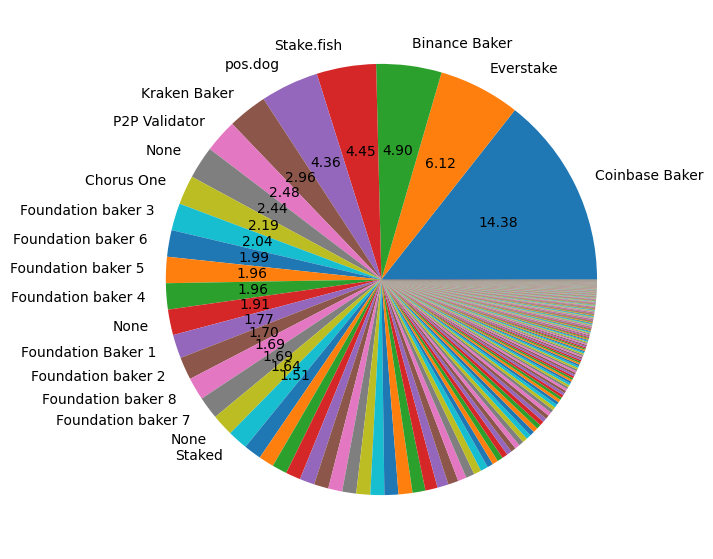

In [13]:
import pandas as pd
#Organize upgrade results in a table compatible with Pandas DataFrame


results_pn = {'alias': [],
              'balance':[],
              'delegatedBalance_int':[],
              #'delegatedBalance':[],
              #'frozenDeposit':[],
              'frozenDepositLimit':[],
              'X_b':[],
              'Y_b':[],
              'shareOfRights':[],
              'stakingBalance': [],
             }

results_index = []

totalDeposit = 0
totalDelegation = 0

for b in bakers:
    results_pn['alias'].append(b['alias'])
    results_pn['delegatedBalance_int'].append(b['delegatedBalance'])
    results_pn['stakingBalance'].append(b['stakingBalance'])
    results_pn['balance'].append(tezify(b['balance']))
    results_pn['frozenDepositLimit'].append(tezify(b['frozenDepositLimit'] or 0))
    X_b = (min(b['frozenDepositLimit'], b['balance']) if b['frozenDepositLimit'] else b['balance'])
    totalDeposit += X_b
    Y_b = min(10*X_b, b['delegatedBalance'])
    totalDelegation += Y_b
    results_pn['X_b'].append(tezify(X_b))
    results_pn['Y_b'].append(tezify(Y_b))

denominator = 2 * totalDeposit + totalDelegation

for b in bakers:
    X_b = (min(b['frozenDepositLimit'], b['balance']) if b['frozenDepositLimit'] else b['balance'])
    Y_b = min(10*X_b, b['delegatedBalance'])
    shareOfRights = (2 * X_b + Y_b) / denominator
    results_pn['shareOfRights'].append(shareOfRights)
    if shareOfRights > 0.014:    
        results_index.append(b['alias'])
    else:
        results_index.append("")
        
# Displaying original stake without adaptive inflation

pd.set_option('display.max_rows', None)
#pd.set_option('precision', 0)

df = pd.DataFrame(results_pn, index = results_index)
df = df.sort_values(by=['delegatedBalance_int'], ascending=False)

df_regular_inflation = pd.DataFrame(results_pn, index = results_index)
df_regular_inflation = df.sort_values(by=['stakingBalance'], ascending=False)


def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1.4 else ''

plot = df_regular_inflation.plot.pie(y='stakingBalance', figsize=(7, 7), legend=False,  autopct=my_autopct ,label="")


If adaptive inflation was active, 6 cycles later, the inflation would be at **1.28%**.
The distribution of baking rights would be:

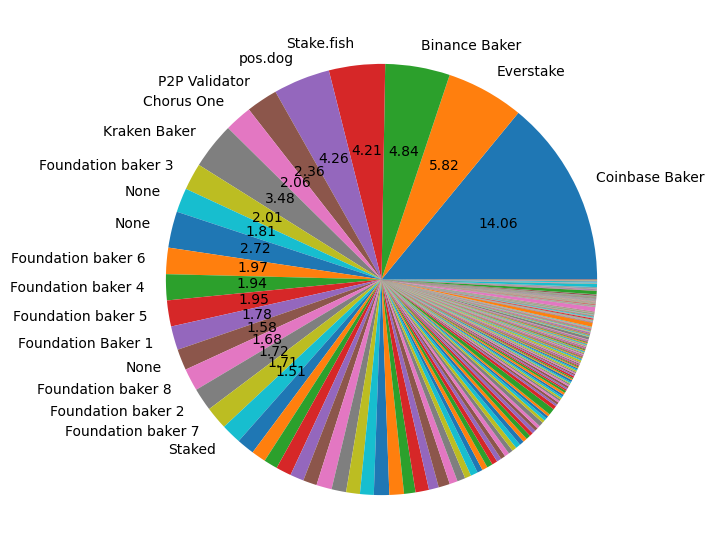

In [14]:
import pandas as pd


#print(f"Total deposit: X = {tezify(totalDeposit)}")
#print(f"Total delegation: Y = {tezify(totalDelegation)}")
#print(f"2* X + Y = {tezify(denominator)}")

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1.4 else ''

plot = df.plot.pie(y='shareOfRights', figsize=(7, 7), legend=False,  autopct=my_autopct ,label="")

totalSupply = stats[0]['totalSupply']
x = totalDeposit/totalSupply
# print(f"Total deposit / totalSupply = {totalDeposit} / {totalSupply} = {x}")

inflation = 2 * (1 / (100 * x)) ** 2

display_markdown(f'''If adaptive inflation was active, 6 cycles later, the inflation would be at **{round(inflation,4)* 100}%**.
The distribution of baking rights would be:''', raw=True)

In [15]:

from IPython.display import display, HTML

display_markdown(f'''
The initial baking rights under adaptive inflation are very similar to today's rights. This is normal.

But people would be encouraged to reallocate their stake, causing the equilibrium to shift.

In particular, private bakers would be expected to cobake more funds, thus shifting the balance to them and reducing the inflation...

Then, public bakers would encourage their delegators to cobake with them, reducing inflation even further.

Feel free to fork this notebook and run your own scenarios by editing the code.

## Appendix

Detail of baking rights per baker:''', raw=True)



The initial baking rights under adaptive inflation are very similar to today's rights. This is normal.

But people would be encouraged to reallocate their stake, causing the equilibrium to shift.

In particular, private bakers would be expected to cobake more funds, thus shifting the balance to them and reducing the inflation...

Then, public bakers would encourage their delegators to cobake with them, reducing inflation even further.

Feel free to fork this notebook and run your own scenarios by editing the code.

## Appendix

Detail of baking rights per baker:

In [21]:
baker_appendix_pn = {'alias': results_pn['alias'],
              'balance':results_pn['balance'],
              'shareOfRights':results_pn['shareOfRights'],
              'earningsPerCycleToday':[],
              'earningsPerCycleUnderAdaptiveInflation': []
                    }

earnings_per_cycle_today = 40000000*8192

number_of_blocks_in_a_year = 2*60*24*365.25

earnings_per_cycle_under_aa = totalSupply * inflation / number_of_blocks_in_a_year * 8192 

for s in baker_appendix_pn['shareOfRights']:
    baker_appendix_pn['earningsPerCycleToday'].append(tezify(earnings_per_cycle_today * s))

    baker_appendix_pn['earningsPerCycleUnderAdaptiveInflation'].append(tezify(earnings_per_cycle_under_aa * s))

    
baker_appendix_df = pd.DataFrame(baker_appendix_pn, index = results_index)
baker_appendix_df = baker_appendix_df.sort_values(by=['shareOfRights'], ascending=False)
display(baker_appendix_df)


,alias,balance,shareOfRights,earningsPerCycleToday,earningsPerCycleUnderAdaptiveInflation
Coinbase Baker,Coinbase Baker,"14,347,872 tez",1.405860e-01,"46,067 tez","13,348 tez"
Everstake,Everstake,"4,809,164 tez",5.822298e-02,"19,078 tez","5,528 tez"
Binance Baker,Binance Baker,"5,365,554 tez",4.844424e-02,"15,874 tez","4,599 tez"
pos.dog,pos.dog,"4,301,970 tez",4.255793e-02,"13,945 tez","4,040 tez"
Stake.fish,Stake.fish,"3,230,592 tez",4.205009e-02,"13,778 tez","3,992 tez"
Kraken Baker,Kraken Baker,"7,701,410 tez",3.477422e-02,"11,394 tez","3,301 tez"
None,None,"5,209,363 tez",2.724747e-02,"8,928 tez","2,587 tez"
P2P Validator,P2P Validator,"1,937,308 tez",2.361763e-02,"7,739 tez","2,242 tez"
Chorus One,Chorus One,"1,485,837 tez",2.057035e-02,"6,740 tez","1,953 tez"
Foundation baker 3,Foundation baker 3,"2,222,416 tez",2.013626e-02,"6,598 tez","1,911 tez"
